# [Nombre Estudiante 1]
# [Nombre Estudiante 2]

# Tarea 1 Deep Learning: Redes Convolucionales
En esta tarea vas a experimentar con redes convolucionales y su comparación con redes MLP. Lo primero que haremos es importar los paquetes importantes para nuestro notebook e inicializar el gpu. Asegúrate que tu notebook se ejecuta sobre un GPU. Si es así, al ejecutar la siguiente celda debería salirte el mensaje "cuda".

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import numpy as np
import random
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

A continuación hay un conjunto de funciones que puedes usar para hacer tus experimentos. Los detalles de cada función están como comentario antes del código de la función.

In [ ]:
#Esta función permite inicializar todas las semillas de números pseudoaleatorios.
# Puedes usar esta función para resetear los generadores de números aleatorios
def iniciar_semillas():
  SEED = 1234

  random.seed(SEED)
  np.random.seed(SEED)
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True

#Función para computar el accuracy. Se asume que predicciones y etiquetas son tensores en el GPU
def calculate_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim=True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float()/y.shape[0]
  return acc

#Función para entrenar una época de un modelo. Recibe como parámetros
#     -model: una red neuronal
#     -iterator: un iterador de la data a usar para el entrenamiento (generalmente creado con un DataLoader)
#     -optimizer: el optimizador para el entrenamiento
#     -criterion: la función de loss
#     -device: dispositivo a usar para el entrenamiento
#
#Devuelve el loss promedio y el accuracy promedio de la época (promedio de todos los batches)
def train_one_epoch(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  #We have to set the neural network in training mode. This is because during
  #training, we need gradients and complementary data to ease the computation
  model.train()

  #Training loop
  for (x, y) in iterator:
    x = x.to(device) #Data
    y = y.long().to(device) #Labels

    optimizer.zero_grad() #Clean gradients

    y_pred = model(x) #Feed the network with data

    loss = criterion(y_pred, y) #Compute the loss

    acc = calculate_accuracy(y_pred, y) #Compute the accuracy

    loss.backward() #Compute gradients

    optimizer.step() #Apply update rules

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss / len(iterator), epoch_acc / len(iterator)

#Función que evalúa una red neuronal con un conjunto de datos de prueba. Recibe como parámetros
#     -model: una red neuronal
#     -iterator: un iterador de la data a usar para el entrenamiento (generalmente creado con un DataLoader)
#     -criterion: la función de loss
#     -device: dispositivo a usar para el entrenamiento
#Devuelve el loss promedio y el accuracy promedio de la época (promedio de todos los batches)
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  #We put the network in testing mode
  #In this mode, Pytorch doesn't use features only reserved for
  #training (dropout for instance)
  model.eval()

  with torch.no_grad(): #disable the autograd engine (save computation and memory)

    for (x, y) in iterator:
      x = x.to(device)
      y = y.long().to(device)

      y_pred= model(x)

      loss = criterion(y_pred, y)

      acc = calculate_accuracy(y_pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

#Calcula el tiempo transcurrido entre dos timestamps
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#Esta función realiza el entrenamiento completo de una red. Recibe como parámetros:
#     -network: la red neuronal
#     -optimizer: el optimizador para entrenamiento
#     -train_loader: el dataloader de datos de entrenamiento
#     -tes_loader: el dataloader de datos de prueba
#     -name: nombre a usar para guardar en disco la red con el mejor accuracy

def train_complete(network, optimizer, train_loader, test_loader, name):

  #Se envían la red y la función de loss al GPU
  network = network.to(device)
  criterion = nn.CrossEntropyLoss()
  criterion = criterion.to(device)

  #Fijar el entrenamiento en 10 épocas siempre
  EPOCHS = 10

  best_valid_acc = float('-inf')
  n_params = sum(p.numel() for p in network.parameters() if p.requires_grad)
  print(f'The model has {n_params:,} trainable parameters')

  for epoch in range(EPOCHS):

    start_time = time.time()

    #Train + validation cycles
    train_loss, train_acc = train_one_epoch(network, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(network, test_loader, criterion, device)

    #Si encontramos un modelo con accuracy de validación mayor, lo guardamos
    if valid_acc > best_valid_acc:
     best_valid_acc = valid_acc
     torch.save(network.state_dict(), f'{name}.pt')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  #Cuando se termina el entrenamiento, cargamos el mejor modelo guardado y calculamos el accuracy de prueba
  network.load_state_dict(torch.load(f'{name}.pt'))

  test_loss , test_acc = evaluate(network, test_loader, criterion, device)
  print(f'Test Loss: {test_loss:.3f} | Mejor test acc: {test_acc*100:.2f}%')

Para nuestros experimentos usaremos el dataset CIFAR10, que consta de imágenes RGB de 32x32 píxeles que representan distintos objetos y animales clasificados en 10 clases. Inicializamos los hiperparámetros y cargamos los conjuntos de datos de entrenamiento y prueba. También se crean los dataloaders correspondientes.

In [ ]:
# Hyper-parameters
input_size = 784
num_classes = 10
batch_size_train = 1000
batch_size_test = 1000
momentum = 0.9
log_interval = 100
learning_rate=0.01
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='data', train=True,
                                        download=True, transform=transform)


test_dataset = torchvision.datasets.CIFAR10(root='data', train=False,
                                       download=True, transform=transform)

# Data loader

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test,
                                         shuffle=False)

class_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Numero de batch: 0
Batch Shape torch.Size([1000, 3, 32, 32])
Target Shape torch.Size([1000])


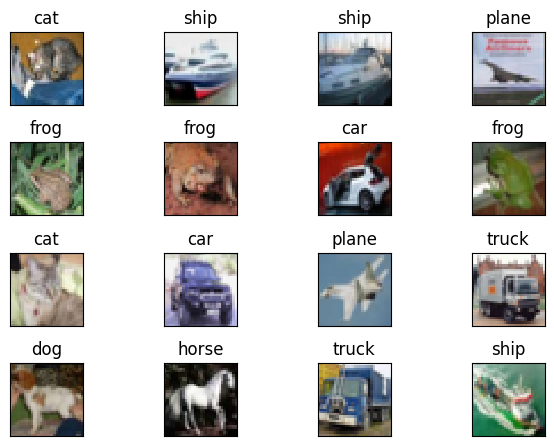

In [ ]:
examples = enumerate(test_loader) #Crea un iterador sobre la lista de batches

batchId, (exampleData, exampleTargets) = next(examples) #Obtenemos el siguiente batch
print('Numero de batch: {}'.format(batchId))
print('Batch Shape', exampleData.shape)
print('Target Shape', exampleTargets.shape)

#Mostramos los primeros 16 elementos del batch con su etiqueta
plt.figure()
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.tight_layout()
  img = exampleData[i] / 2 + 0.5 # unnormalize
  img = img.permute(1, 2, 0)
  plt.imshow(img, interpolation='none')
  plt.title(class_names[exampleTargets[i]])
  plt.xticks([])
  plt.yticks([])

# Parte 1

Crea una arquitectura de red neuronal MLP que procese datos con la forma Bx3x32x32, donde B representa el tamaño del batch, y que cuente con 10 neuronas en la capa de salida. Para ello, primero transforma el tensor de entrada de la forma Bx3x32x32 a Bx(33232) para que pueda ser utilizado en una capa lineal. Además, utiliza la función ReLU como activación en todas las capas ocultas y la función softmax en la capa de salida. Ten en cuenta que si aplicas nn.CrossEntropyLoss, no es necesario añadir ninguna función adicional en la última capa de la red.


In [ ]:
#Creamos la red neuronal
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    # Define aquí las capas de tu red
    ...

  def forward(self, x):
    #Implementa la función forward usando la función de activación ReLU en las capas ocultas
    pass



Para ejecutar el entrenamiento de tu primer modelo, ejecuta la siguiente celda y debería reportarte el accuracy de prueba de este primer experimento. Cuánto obtienes de accuracy de test?

In [ ]:
iniciar_semillas() # Se inicializan las semillas
network = MLP() # Creas la red
optimizer = optim.Adam(network.parameters(), lr=learning_rate) #Creas el optimizador
train_complete(network, optimizer, train_loader, test_loader, 'mlp') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 10 épocas)

# Parte 2
En esta parte vas a comparar el accuracy de test de la primera red que creaste (red multilayer perceptron) y los accuracys obtenidos usando redes convolucionales. Para completar esta parte debes hacer lo siguiente:



*   Implementar la red convolucional: Crea una arquitectura que reciba imágenes RGB de 32x32 y tenga 10 neuronas de salida. Usa ReLU como función de activación , softmax en la capa de salida, y añade capas de max pooling para reducir el tamaño de los mapas de características.
*   Entrena cada red usando la función "train_complete" usando el mismo optimizador siempre.
*   Registra los accuracys que obtengas. Prueba distintas combinaciones de hiperparametros y arquitecturas para obtener los mejores resultados posibles. Evita utilizar redes muy profundas ya que estas pueden tener mayor dificultad para aprender.
*   Discute los resultados obtenidos. Incluye en tu analisis la respuesta a las siguientes preguntas:
    * Teóricamente, ¿qué tipo de red debería obtener mejores resultados al tratar con imágenes: una red convolucional o una MLP? ¿Por qué?
    * Según tus resultados, ¿qué arquitectura funcionó mejor? ¿Por qué crees que esto ocurrió así?
    * Antes mencionamos que las redes muy profundas son más difíciles de entrenar. ¿Al probar distintas arquitecturas, encontraste que se daba este fenómeno? ¿Por qué crees que ocurre esto? ¿Cómo podrías intentar solucionarlo?



In [ ]:
#Creamos la red neuronal
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    # Define aquí las capas de tu red
    ...

  def forward(self, x):
    #Implementa la función forward usando la función de activación ReLU y max pooling en las capas ocultas
    pass



In [ ]:
iniciar_semillas() # Se inicializan las semillas
network = CNN() # Creas la red
optimizer = optim.Adam(network.parameters(), lr=learning_rate) #Creas el optimizador
train_complete(network, optimizer, train_loader, test_loader, 'cnn') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 10 épocas)

# Parte 3
En esta parte, probaremos qué ocurre si se eliminan las capas de max pooling de la red que creaste en la parte 2. Para completar esta sección, debes hacer lo siguiente:

*   Copia la implementación de la red convolucional y elimina las capas de pooling. Intenta cambiar lo menos posible la implementación, solo adapta las dimensiones de la red para ajustarlas tras haber removido el pooling.
*   Entrena cada red usando la función "train_complete" usando el mismo optimizador siempre.
*   Registra los accuracys que obtengas.
*   Discute los resultados obtenidos. Incluye en tu análisis la respuesta a las siguientes preguntas:
    * ¿Cómo se comparan los resultados obtenidos con los del modelo de la parte anterior? ¿Cómo explicas lo obtenido experimentalmente? ¿Cómo varía la cantidad de parámetros del modelo de la parte anterior en comparación con este?
    * ¿Cuál es la utilidad de las capas de pooling? Si utilizáramos imágenes de mayor tamaño, ¿crees que el pooling sería más o menos necesario? Justifica tu respuesta.

In [ ]:
#Creamos la red neuronal
class CNN_sin_pooling(nn.Module):
  def __init__(self):
    super(CNN_sin_pooling, self).__init__()
    # Define aquí las capas de tu red
    ...

  def forward(self, x):
    #Implementa la función forward aqui
    pass



In [ ]:
iniciar_semillas() # Se inicializan las semillas
network = CNN_sin_pooling() # Creas la red
optimizer = optim.Adam(network.parameters(), lr=learning_rate) #Creas el optimizador
train_complete(network, optimizer, train_loader, test_loader, 'CNN_sin_pooling') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 10 épocas)

# Parte 4

En esta parte probaremos la arquitectura de ResNet y como este resuelve el problema del desvanecimiento de gradiente. Para eso ejecuta las siguientes celdas y responde las siguientes preguntas:

* ¿Cómo se comparan los resultados con los de las partes anteriores? ¿Cómo varía la cantidad de parámetros?
* ¿Cómo se estructuran las conexiones en ResNet para abordar el problema del desvanecimiento del gradiente y qué papel juegan las "skip connections" en esta arquitectura?


In [ ]:
from torchvision.models import resnet34

In [ ]:
m = resnet34()
m.fc = nn.Linear(512, 10)

In [ ]:
iniciar_semillas() # Se inicializan las semillas
network = m # Creas la red
optimizer = optim.Adam(network.parameters(), lr=learning_rate) #Creas el optimizador
train_complete(network, optimizer, train_loader, test_loader, 'resnet') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 10 épocas)